In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Input
from sklearn.linear_model import LinearRegression

In [2]:
# Konfigurasi saham yang akan diprediksi
STOCK_TICKER = "TLKM.JK"
PREDICTION_DAYS = 30
PERIOD = "5y"
SEQUENCE_LENGTH = 60

In [3]:
# Fungsi untuk mendapatkan data saham dari Yahoo Finance
def get_stock_data(ticker, period=PERIOD):
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    time.sleep(2)
    return hist

In [4]:
stock_data = get_stock_data(STOCK_TICKER)
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-05-20 00:00:00+07:00,2529.046040,2576.465653,2513.239502,2513.239502,76086600,0.0,0.0
2020-05-26 00:00:00+07:00,2489.529571,2592.272061,2473.723034,2568.562256,105792900,0.0,0.0
2020-05-27 00:00:00+07:00,2568.562081,2584.368617,2489.529402,2505.335938,128693900,0.0,0.0
2020-05-28 00:00:00+07:00,2513.239241,2536.949045,2473.722900,2473.722900,177385100,0.0,0.0
2020-05-29 00:00:00+07:00,2450.013199,2489.529541,2434.206662,2489.529541,276092100,0.0,0.0
...,...,...,...,...,...,...,...
2025-05-14 00:00:00+07:00,2530.000000,2620.000000,2530.000000,2590.000000,132760900,0.0,0.0
2025-05-15 00:00:00+07:00,2580.000000,2690.000000,2580.000000,2660.000000,120039700,0.0,0.0
2025-05-16 00:00:00+07:00,2710.000000,2750.000000,2680.000000,2740.000000,101569600,0.0,0.0


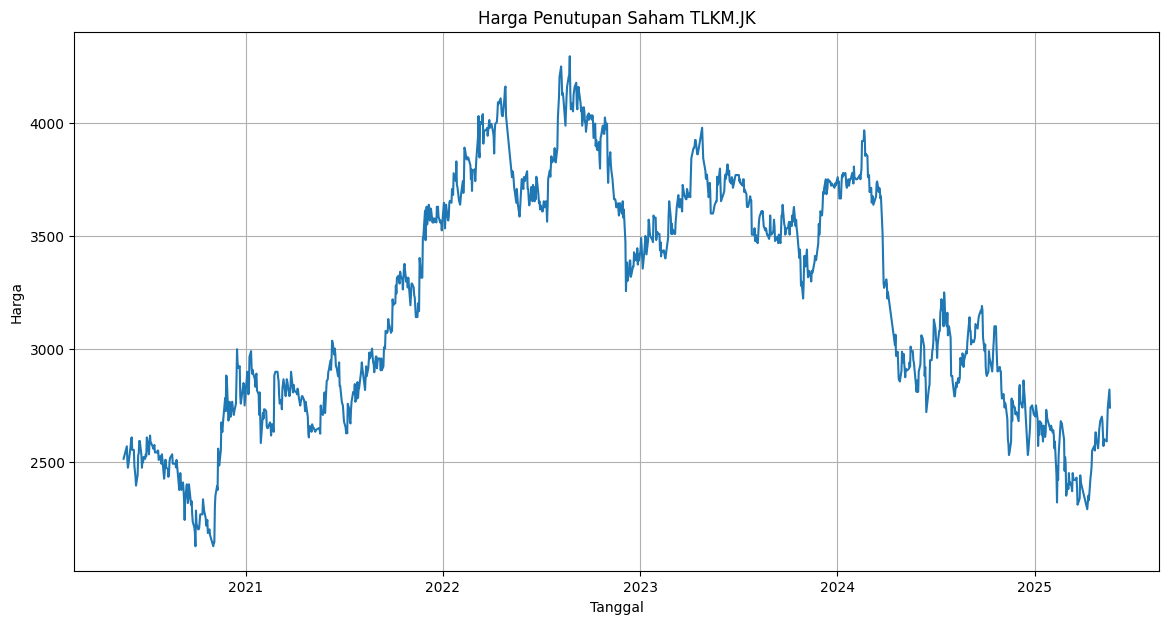

In [5]:
# Melihat pergerakan harga saham
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'])
plt.title(f'Harga Penutupan Saham {STOCK_TICKER}')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.grid(True)
plt.show()

In [6]:
def prepare_data_for_lstm(data, sequence_length=SEQUENCE_LENGTH):
    data_close = data['Close'].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_close)

    X_train = []
    y_train = []
    all_dates = []

    for i in range(sequence_length, len(data_scaled)):
        X_train.append(data_scaled[i-sequence_length:i, 0])
        y_train.append(data_scaled[i, 0])
        all_dates.append(data.index[i])

    train_size = int(len(X_train) * 0.8)

    xt_train = X_train[:train_size]
    xt_val = X_train[train_size:]
    Yl_train = y_train[:train_size]
    Yl_val = y_train[train_size:]

    train_dates = all_dates[:train_size]
    val_dates = all_dates[train_size:]

    # Konversi list ke numpy array
    X_train, y_train = np.array(xt_train), np.array(Yl_train)
    X_val, y_val = np.array(xt_val), np.array(Yl_val)

    # Reshape data untuk LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

    return scaler, data_scaled, X_train, y_train, X_val, y_val, train_dates, val_dates


In [7]:
scaler, data_scaled, X_train, y_train, X_val, y_val, train_dates, val_dates = prepare_data_for_lstm(stock_data)

In [8]:
# Fungsi untuk membuat beberapa model berbeda
def create_ensemble_models(input_shape, num_features=1):
    # Model 1: LSTM sederhana
    model1_input = Input(shape=input_shape)
    model1_lstm = LSTM(50)(model1_input)
    model1_dense = Dense(1)(model1_lstm)
    model1 = Model(inputs=model1_input, outputs=model1_dense, name='lstm_model')

    # Model 2: GRU
    model2_input = Input(shape=input_shape)
    model2_gru = GRU(50)(model2_input)
    model2_dense = Dense(1)(model2_gru)
    model2 = Model(inputs=model2_input, outputs=model2_dense, name='gru_model')

    # Model 3: Bidirectional LSTM
    model3_input = Input(shape=input_shape)
    model3_bilstm = Bidirectional(LSTM(25))(model3_input)
    model3_dense = Dense(1)(model3_bilstm)
    model3 = Model(inputs=model3_input, outputs=model3_dense, name='bilstm_model')

    # Model 4: Deeper LSTM
    model4_input = Input(shape=input_shape)
    model4_lstm1 = LSTM(64, return_sequences=True)(model4_input)
    model4_lstm2 = LSTM(32)(model4_lstm1)
    model4_dense1 = Dense(16, activation='relu')(model4_lstm2)
    model4_dense2 = Dense(1)(model4_dense1)
    model4 = Model(inputs=model4_input, outputs=model4_dense2, name='deep_lstm_model')

    # Compile masing-masing model
    models = [model1, model2, model3, model4]
    for model in models:
        model.compile(optimizer='adam', loss='mean_squared_error')

    return models

In [9]:
# Fungsi untuk melatih setiap model
def train_ensemble_models(models, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    trained_models = []
    histories = []

    for i, model in enumerate(models):
        print(f"Training model {i+1}/{len(models)}: {model.name}")
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            verbose=1
        )
        trained_models.append(model)
        histories.append(history)

    return trained_models, histories

In [10]:
dl_models = create_ensemble_models((X_train.shape[1], 1))

In [11]:
trained_dl_models, histories = train_ensemble_models(dl_models, X_train, y_train, X_val, y_val)

Training model 1/4: lstm_model
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1817 - val_loss: 0.0037
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 12/50
29/29 ━━━━━━━━━━━━━━

In [12]:
individual_predictions_train = {}
for i, model in enumerate(trained_dl_models):
    pred = model.predict(X_train)
    # pred = scaler.inverse_transform(pred)
    individual_predictions_train[model.name] = pred.flatten()

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


In [13]:
individual_predictions_val = {}
for i, model in enumerate(trained_dl_models):
    pred = model.predict(X_val)
    # pred = scaler.inverse_transform(pred)
    individual_predictions_val[model.name] = pred.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [14]:
train_preds = list(individual_predictions_train.values())  # list of arrays
val_preds = list(individual_predictions_val.values())

X_stack_train = np.stack(train_preds, axis=1)
X_stack_val = np.stack(val_preds, axis=1)

In [15]:
print("Sample train_preds:", val_preds[0][:5])  # lihat 5 prediksi awal dari model pertama
print("X_stack_val shape:", X_stack_val.shape)
print("X_stack_val sample:", X_stack_val[:5])

Sample train_preds: [0.33300477 0.34702116 0.3676054  0.3862034  0.4016417 ]
X_stack_val shape: (229, 4)
X_stack_val sample: [[0.33300477 0.3598583  0.34203216 0.3404453 ]
 [0.34702116 0.38805023 0.35789764 0.3631331 ]
 [0.3676054  0.41633204 0.3794093  0.39168605]
 [0.3862034  0.42167917 0.39893284 0.4139242 ]
 [0.4016417  0.42303804 0.41549554 0.42820144]]


In [16]:
# Debug: Cetak 5 prediksi pertama untuk setiap model
for model_name, preds in individual_predictions_val.items():
    print(f"{model_name} predictions (first 5): {preds[:5]}")
    print(f"{model_name} prediction shape: {preds.shape}")
    print(f"{model_name} unique values: {np.unique(preds).shape[0]}")
    print("-" * 50)

# Verifikasi bentuk data
print(f"X_val shape: {X_val.shape}")

lstm_model predictions (first 5): [0.33300477 0.34702116 0.3676054  0.3862034  0.4016417 ]
lstm_model prediction shape: (229,)
lstm_model unique values: 229
--------------------------------------------------
gru_model predictions (first 5): [0.3598583  0.38805023 0.41633204 0.42167917 0.42303804]
gru_model prediction shape: (229,)
gru_model unique values: 229
--------------------------------------------------
bilstm_model predictions (first 5): [0.34203216 0.35789764 0.3794093  0.39893284 0.41549554]
bilstm_model prediction shape: (229,)
bilstm_model unique values: 229
--------------------------------------------------
deep_lstm_model predictions (first 5): [0.3404453  0.3631331  0.39168605 0.4139242  0.42820144]
deep_lstm_model prediction shape: (229,)
deep_lstm_model unique values: 229
--------------------------------------------------
X_val shape: (229, 60, 1)


In [17]:
# Model meta-ensemble
meta_model = LinearRegression()

meta_model.fit(X_stack_train, y_train)

LinearRegression()

In [18]:
# prediksi menggunakan meta model
ensemble_preds_hist_train = meta_model.predict(X_stack_train)
ensemble_preds_hist_val = meta_model.predict(X_stack_val)

In [19]:
# Fungsi untuk mengubah prediksi ensemble berdasarkan sentimen
def predict_ensemble(models, scaler, last_sequence, meta_model, prediction_days=30, sentiment_score=0):

    ensemble_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(prediction_days):
        model_predictions = []
        current_sequence_reshaped = np.reshape(current_sequence, (1, current_sequence.shape[0], 1))

        # Prediksi dari setiap model
        for model in models:
            next_day = model.predict(current_sequence_reshaped, verbose=0)[0][0]
            model_predictions.append(next_day)

        # prediksi dari semua model
        model_predictions = np.array(model_predictions).reshape(1, -1)

        next_day_ensemble = meta_model.predict(model_predictions)[0]

        # Tambahkan sedikit noise
        noise = np.random.normal(0, 0.002, 1)[0]
        next_day_ensemble += noise

        # Tambahkan ke hasil prediksi
        ensemble_predictions.append(next_day_ensemble)

        # karena sentimen hanya mempengaruhi output akhir
        current_sequence = np.append(current_sequence[1:], next_day_ensemble)

    # Mengembalikan nilai ke skala asli
    ensemble_predictions_scaled = np.array(ensemble_predictions).reshape(-1, 1)
    ensemble_predictions_original = scaler.inverse_transform(ensemble_predictions_scaled)

    return ensemble_predictions_original

In [20]:
last_date = stock_data.index[-1]

In [21]:
last_sequence = data_scaled[-SEQUENCE_LENGTH:]
future_predictions_base = predict_ensemble(
    trained_dl_models, scaler, last_sequence, meta_model)

In [22]:
future_dates = []
current_date = last_date
while len(future_dates) < PREDICTION_DAYS:
    current_date += datetime.timedelta(days=1)
    if current_date.weekday() < 5:
        future_dates.append(current_date)

In [23]:
def plot_ensemble_predictions(data, scaler, train_dates, val_dates,
                              individual_predictions_train, individual_predictions_val,
                              ensemble_predictions_train, ensemble_predictions_val,
                              future_dates, future_predictions, ticker):

    plt.figure(figsize=(14, 8))

    # Plot data historis (aktual)
    plt.plot(data.index, data['Close'], label='Harga Aktual', color='blue', linewidth=2)

    # Plot prediksi dari model-model individual
    colors = ['lightgray', 'darkgray', 'silver', 'gray']
    # Untuk model individual
    for i, (model_name, preds_train) in enumerate(individual_predictions_train.items()):
        # Plot prediksi train
        plt.plot(train_dates, scaler.inverse_transform(preds_train.reshape(-1, 1)),
                label=f'{model_name} (Train)', color=colors[i % len(colors)],
                alpha=0.4, linewidth=1, linestyle='--')

        # Plot prediksi validasi jika ada
        if model_name in individual_predictions_val:
            plt.plot(val_dates, scaler.inverse_transform(individual_predictions_val[model_name].reshape(-1, 1)),
                    label=f'{model_name} (Val)', color=colors[i % len(colors)],
                    alpha=0.7, linewidth=1, linestyle='-.')

    # Plot ensemble train dan val
    plt.plot(train_dates, scaler.inverse_transform(ensemble_predictions_train.reshape(-1, 1)), label='Ensemble (Train)', color='green', linewidth=2)
    plt.plot(val_dates, scaler.inverse_transform(ensemble_predictions_val.reshape(-1, 1)), label='Ensemble (Val)', color='red', linewidth=2, linestyle='--')

    # Plot prediksi masa depan
    plt.plot(future_dates, future_predictions, label='Prediksi masa depan', color='orange', linewidth=2)

    # Garis vertikal untuk hari terakhir aktual
    latest_date = data.index[-1]
    plt.axvline(x=latest_date, color='black', linestyle='--', label='Hari Ini')

    # Judul dan label
    plt.title(f'Prediksi Ensemble Harga Saham {ticker} - 30 Hari ke Depan',
              fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Harga Saham', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"{ticker}_ensemble_prediction.png", dpi=300)
    plt.show()


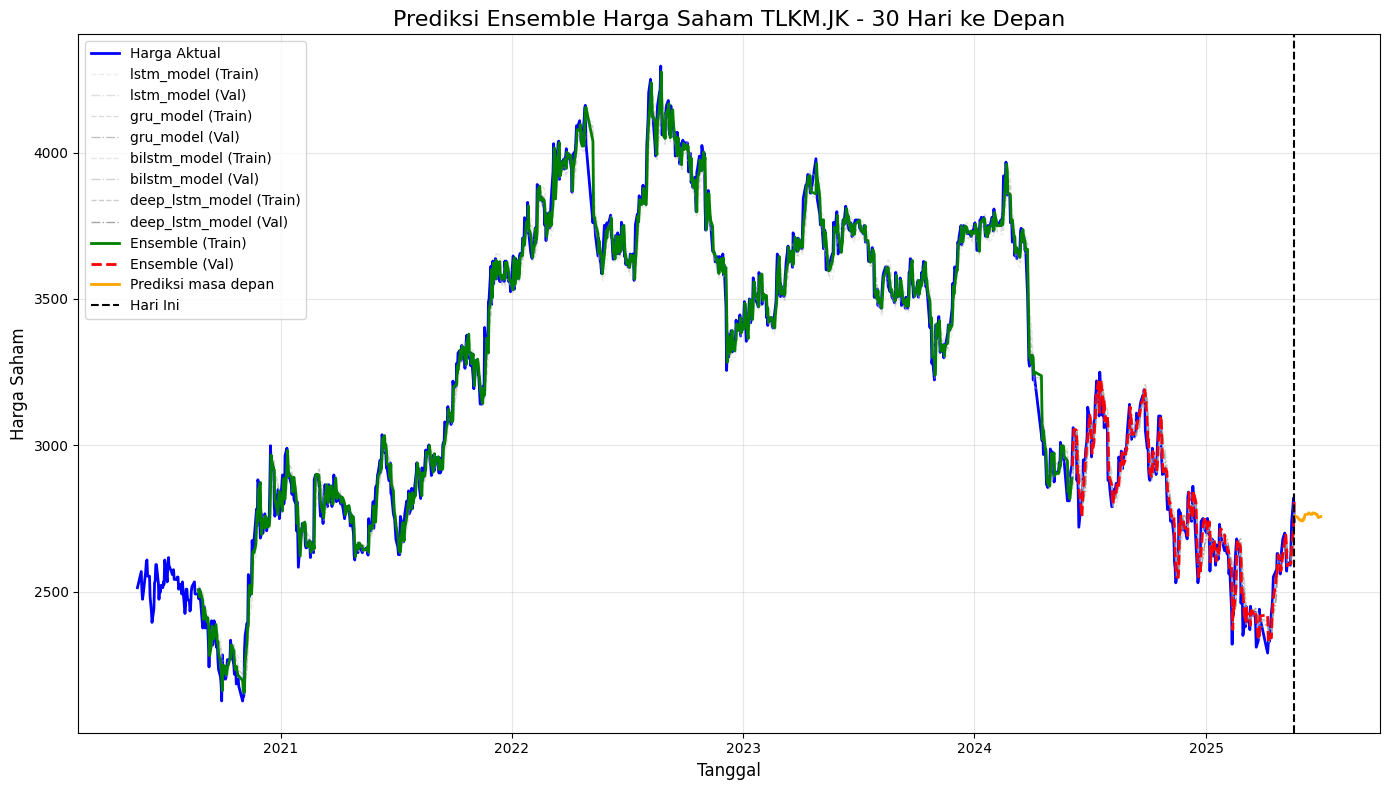

In [24]:
plot_ensemble_predictions(
    stock_data, scaler, train_dates, val_dates, individual_predictions_train,
    individual_predictions_val, ensemble_preds_hist_train, ensemble_preds_hist_val,
    future_dates, future_predictions_base, STOCK_TICKER,
)

In [25]:
# Menampilkan hasil prediksi masa depan dalam bentuk DataFrame
df_prediksi_masa_depan = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi Harga': future_predictions_base.flatten()
})
df_prediksi_masa_depan.set_index('Tanggal', inplace=True)
df_prediksi_masa_depan


,Prediksi Harga
Tanggal,
2025-05-21 00:00:00+07:00,2760.024737
2025-05-22 00:00:00+07:00,2753.686854
2025-05-23 00:00:00+07:00,2756.449554
2025-05-26 00:00:00+07:00,2753.443163
2025-05-27 00:00:00+07:00,2748.364143
2025-05-28 00:00:00+07:00,2746.707726
2025-05-29 00:00:00+07:00,2743.663058
2025-05-30 00:00:00+07:00,2744.879498
2025-06-02 00:00:00+07:00,2740.718335


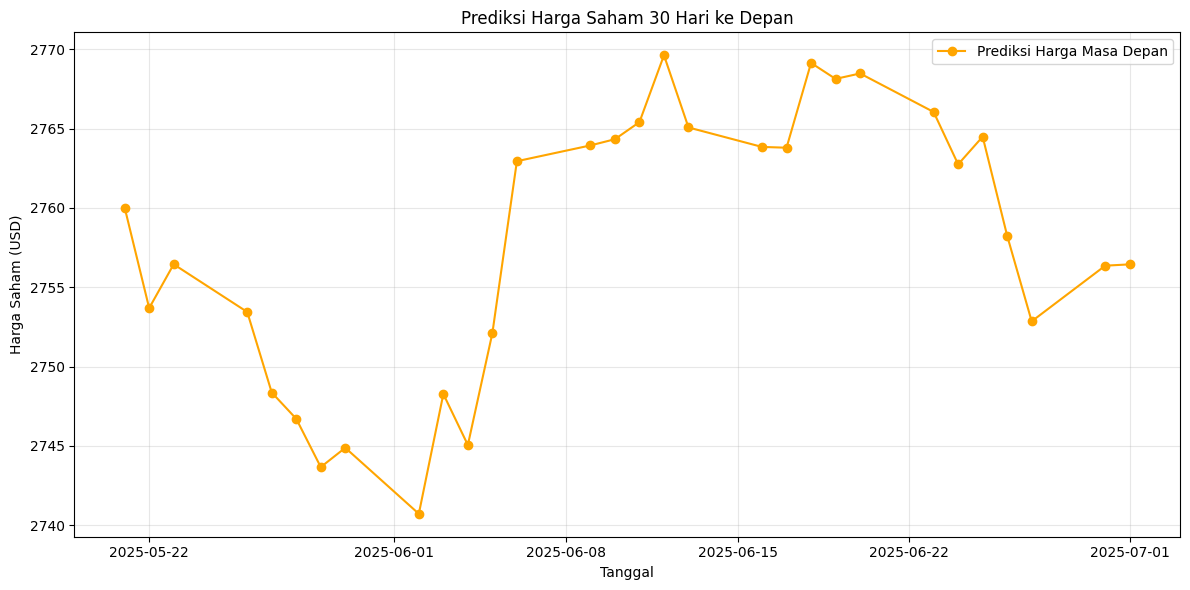

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_base, marker='o', color='orange', label='Prediksi Harga Masa Depan')
plt.title('Prediksi Harga Saham 30 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham (USD)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

mape = mean_absolute_percentage_error(y_val, preds)
mae = mean_absolute_error(y_val, preds)
mse = mean_squared_error(y_val, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, preds)

print(f"Evaluasi Deep LSTM Model pada Data Validasi:")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.4f}%")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R2   : {r2:.4f}")

Evaluasi Deep LSTM Model pada Data Validasi:
MAE  : 0.0293
MAPE : 12.1041%
MSE  : 0.0014
RMSE : 0.0374
R2   : 0.8840
